### Import

In [47]:
import glob
import os 
import subprocess
import numpy as np
from torch.utils.data import Dataset
from scipy.sparse import csr_matrix, csc_matrix
from sklearn.metrics.pairwise import cosine_similarity

### Path et collectes

In [2]:
data_dir="/info/raid-etu/m2/s2101052/data100repos/"

In [3]:
size_mb = int(subprocess.check_output(["du", "-sm", data_dir]).split()[0])
size_gb = size_mb / 1024
print(f"{size_gb:.2f} Go")

0.08 Go


In [4]:
paths=glob.glob(os.path.join(data_dir, '*.txt'))

In [5]:
paths=sorted(paths)

In [6]:
with open(paths[0],"rb") as f:
    data=f.read()

In [7]:
data_lue = dict()
tmp=0
for path in paths:
    with open(path, "r", encoding="utf-8") as f:
        tmp=0
        for ligne in f:
            login, reste = ligne.strip().split(" : [", 1)
            repos_str = reste.rstrip("]\n")
            repos = [r.strip() for r in repos_str.split(",")] if repos_str else []
            data_lue[login]= repos
            tmp+=1
        print(path,":",tmp , "reel :",len(data_lue.keys()))

/info/raid-etu/m2/s2101052/data100repos/resultats000000-048968-100repos.txt : 4330 reel : 4330
/info/raid-etu/m2/s2101052/data100repos/resultats007000-010000-100repos.txt : 325 reel : 4359
/info/raid-etu/m2/s2101052/data100repos/resultats010000-018000-100repos.txt : 696 reel : 4419
/info/raid-etu/m2/s2101052/data100repos/resultats018000-030000-100repos.txt : 977 reel : 4511
/info/raid-etu/m2/s2101052/data100repos/resultats030000-040000-100repos.txt : 719 reel : 4583
/info/raid-etu/m2/s2101052/data100repos/resultats040000-050000-100repos.txt : 764 reel : 4630
/info/raid-etu/m2/s2101052/data100repos/resultats050000-080000-100repos.txt : 1961 reel : 6311
/info/raid-etu/m2/s2101052/data100repos/resultats080000-100000-100repos.txt : 1141 reel : 7452
/info/raid-etu/m2/s2101052/data100repos/resultats100000-130000-100repos.txt : 1731 reel : 9183
/info/raid-etu/m2/s2101052/data100repos/resultats1000000-1200000-100repos.txt : 5648 reel : 14831
/info/raid-etu/m2/s2101052/data100repos/resultats120

In [8]:
len(data_lue.keys())

51456

### Traitement des données

In [9]:
mes_repos = set()
for key in data_lue.keys():
    for val in data_lue[key]:
        mes_repos.add(val)

In [10]:
len(mes_repos)

11047

In [11]:
repos2index = dict()
for idx, repo in enumerate(mes_repos):
    repos2index[repo] = idx

In [12]:
mat_u = np.zeros((len(data_lue.keys()), len(mes_repos)))
mat_u.shape

(51456, 11047)

In [13]:
idx = 0
for key in data_lue.keys():
    for val in data_lue[key]:
        if val in repos2index.keys():
            mat_u[idx][repos2index[val]] = 1
    idx += 1

In [14]:
np.sum(mat_u, axis=1)

array([100., 100., 100., ..., 100., 100., 100.])

### Graphique

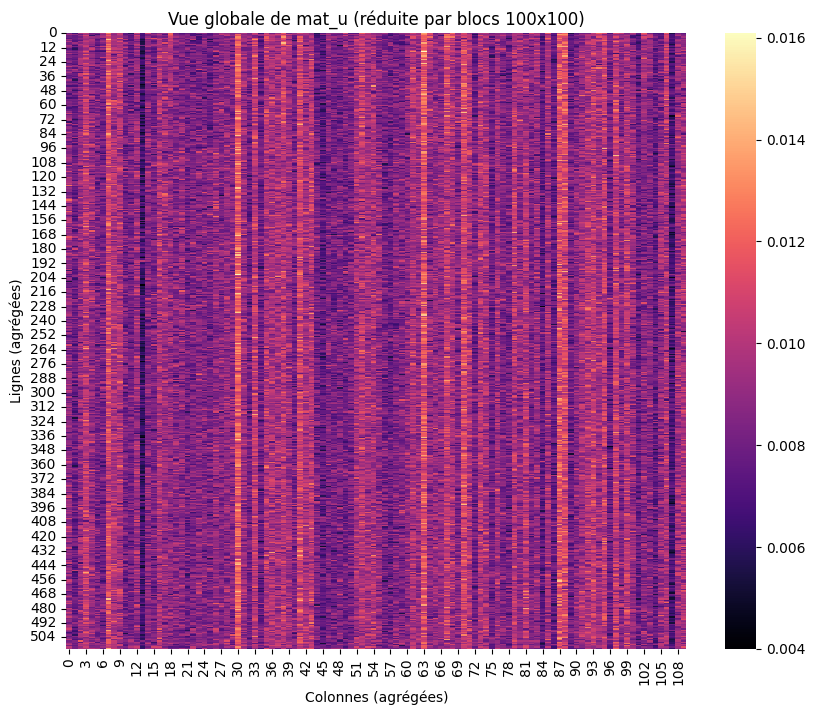

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

block_size = 100

# Dimensions actuelles
n_rows, n_cols = mat_u.shape

# On rogne pour tomber sur un multiple de block_size
n_rows_trim = (n_rows // block_size) * block_size
n_cols_trim = (n_cols // block_size) * block_size
mat_trimmed = mat_u[:n_rows_trim, :n_cols_trim]

# Moyennage par blocs
mat_small = mat_trimmed.reshape(
    n_rows_trim // block_size, block_size,
    n_cols_trim // block_size, block_size
).mean(axis=(1, 3))

# Affichage
plt.figure(figsize=(10, 8))
sns.heatmap(mat_small, cmap="magma", cbar=True)
plt.title(f"Vue globale de mat_u (réduite par blocs {block_size}x{block_size})")
plt.xlabel("Colonnes (agrégées)")
plt.ylabel("Lignes (agrégées)")
plt.show()


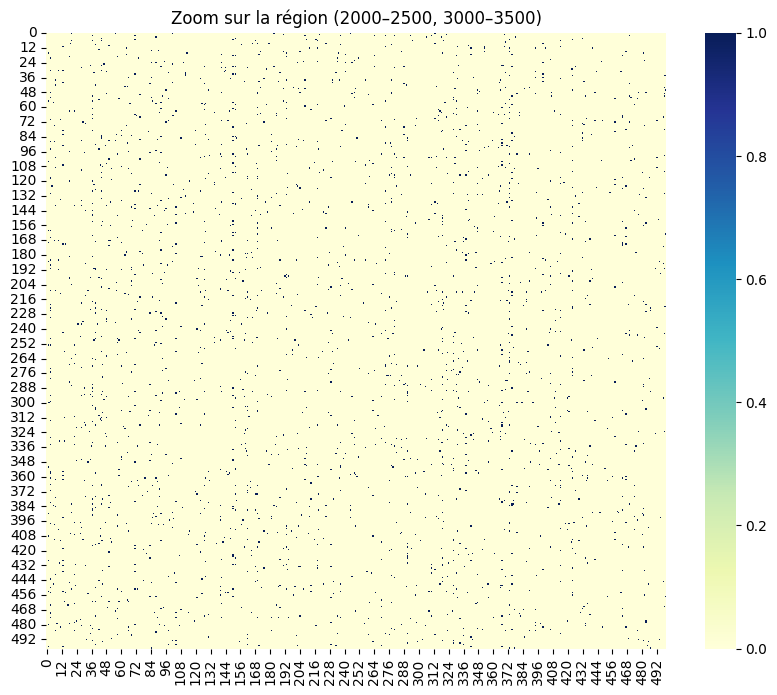

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(mat_u[2000:2500, 3000:3500], cmap="YlGnBu", cbar=True)
plt.title("Zoom sur la région (2000–2500, 3000–3500)")
plt.show()


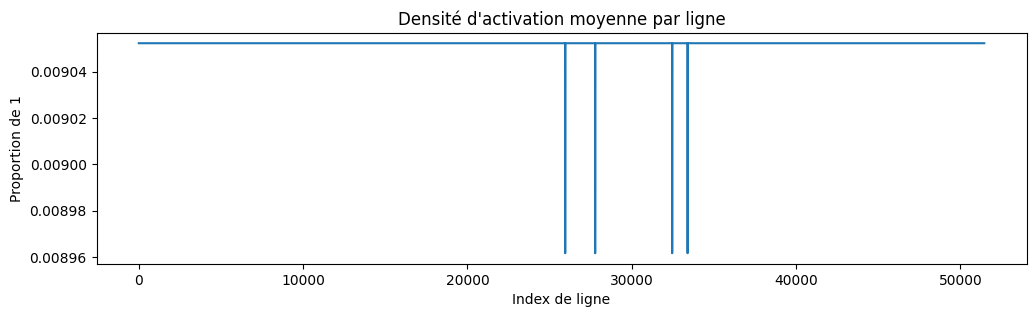

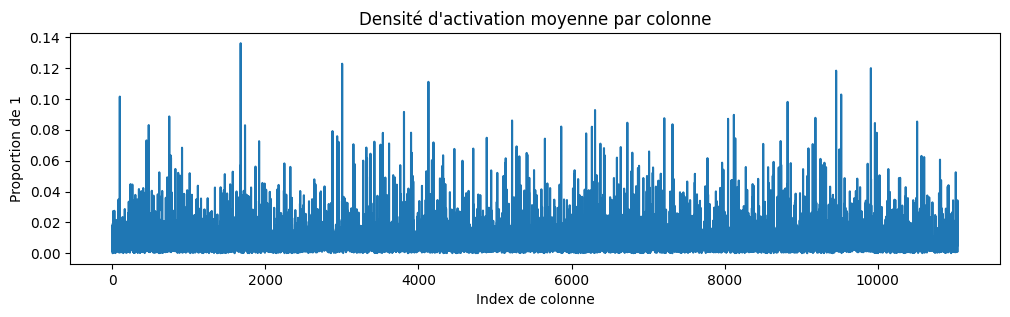

In [17]:
# Moyenne par ligne et par colonne
density_rows = mat_u.mean(axis=1)
density_cols = mat_u.mean(axis=0)

# Profil par ligne
plt.figure(figsize=(12, 3))
plt.plot(density_rows)
plt.title("Densité d'activation moyenne par ligne")
plt.xlabel("Index de ligne")
plt.ylabel("Proportion de 1")
plt.show()

# Profil par colonne
plt.figure(figsize=(12, 3))
plt.plot(density_cols)
plt.title("Densité d'activation moyenne par colonne")
plt.xlabel("Index de colonne")
plt.ylabel("Proportion de 1")
plt.show()


(51456, 11047) avec 5145596 activations


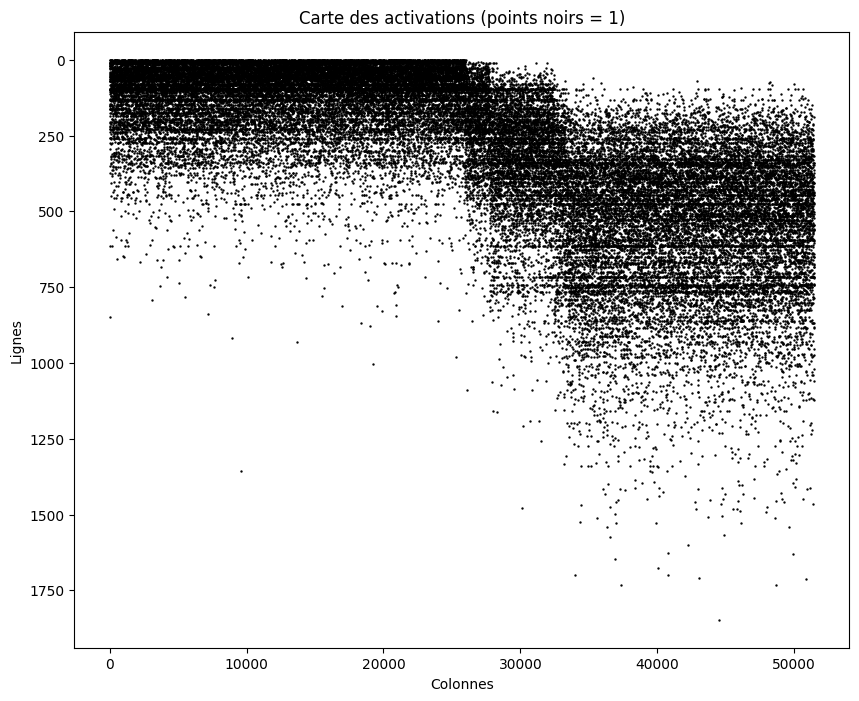

In [18]:
mat_u_sparse = csr_matrix(mat_u)
print(mat_u_sparse.shape, "avec", mat_u_sparse.nnz, "activations")

rows, cols = mat_u_sparse.nonzero()
plt.figure(figsize=(10, 8))
plt.scatter(rows[::100], cols[::100], s=0.5, c='black')
plt.gca().invert_yaxis()
plt.title("Carte des activations (points noirs = 1)")
plt.xlabel("Colonnes")
plt.ylabel("Lignes")
plt.show()

### Matrice CSC, CSR et SVD

In [19]:
mat_u_csc = csc_matrix(mat_u)
print(mat_u_csc)

  (162, 0)	1.0
  (420, 0)	1.0
  (1033, 0)	1.0
  (1438, 0)	1.0
  (1584, 0)	1.0
  (1665, 0)	1.0
  (2687, 0)	1.0
  (2754, 0)	1.0
  (3171, 0)	1.0
  (3285, 0)	1.0
  (3301, 0)	1.0
  (3416, 0)	1.0
  (3502, 0)	1.0
  (4051, 0)	1.0
  (4110, 0)	1.0
  (4407, 0)	1.0
  (4413, 0)	1.0
  (4419, 0)	1.0
  (4887, 0)	1.0
  (5235, 0)	1.0
  (5936, 0)	1.0
  (5947, 0)	1.0
  (7019, 0)	1.0
  (7180, 0)	1.0
  (7208, 0)	1.0
  :	:
  (49861, 11046)	1.0
  (49881, 11046)	1.0
  (49936, 11046)	1.0
  (49956, 11046)	1.0
  (50119, 11046)	1.0
  (50195, 11046)	1.0
  (50276, 11046)	1.0
  (50296, 11046)	1.0
  (50312, 11046)	1.0
  (50324, 11046)	1.0
  (50335, 11046)	1.0
  (50393, 11046)	1.0
  (50399, 11046)	1.0
  (50593, 11046)	1.0
  (50605, 11046)	1.0
  (50699, 11046)	1.0
  (50702, 11046)	1.0
  (50723, 11046)	1.0
  (50740, 11046)	1.0
  (50755, 11046)	1.0
  (50906, 11046)	1.0
  (50947, 11046)	1.0
  (50960, 11046)	1.0
  (51138, 11046)	1.0
  (51160, 11046)	1.0


In [20]:
mat_u_csr = csr_matrix(mat_u)
print(mat_u_csr)

  (0, 18)	1.0
  (0, 372)	1.0
  (0, 439)	1.0
  (0, 447)	1.0
  (0, 510)	1.0
  (0, 606)	1.0
  (0, 614)	1.0
  (0, 674)	1.0
  (0, 724)	1.0
  (0, 744)	1.0
  (0, 750)	1.0
  (0, 870)	1.0
  (0, 969)	1.0
  (0, 1099)	1.0
  (0, 1267)	1.0
  (0, 1307)	1.0
  (0, 1461)	1.0
  (0, 1523)	1.0
  (0, 1574)	1.0
  (0, 1727)	1.0
  (0, 1734)	1.0
  (0, 1735)	1.0
  (0, 1892)	1.0
  (0, 1894)	1.0
  (0, 1895)	1.0
  :	:
  (51455, 7625)	1.0
  (51455, 7722)	1.0
  (51455, 7891)	1.0
  (51455, 8196)	1.0
  (51455, 8235)	1.0
  (51455, 8244)	1.0
  (51455, 8482)	1.0
  (51455, 8708)	1.0
  (51455, 8791)	1.0
  (51455, 8892)	1.0
  (51455, 8953)	1.0
  (51455, 9211)	1.0
  (51455, 9232)	1.0
  (51455, 9468)	1.0
  (51455, 9500)	1.0
  (51455, 9660)	1.0
  (51455, 9800)	1.0
  (51455, 9816)	1.0
  (51455, 9911)	1.0
  (51455, 10024)	1.0
  (51455, 10197)	1.0
  (51455, 10686)	1.0
  (51455, 10779)	1.0
  (51455, 10801)	1.0
  (51455, 11032)	1.0


In [21]:
U, S, V = np.linalg.svd(mat_u)

In [22]:
U.shape

(51456, 51456)

In [23]:
S_diag = np.diag(S) @ np.diag(S)
S_diag.shape

(11047, 11047)

In [24]:
V.shape

(11047, 11047)

### Dataset

In [25]:
class Dataset(Dataset):

    def __init__(self, data_dir):
        self.data = []
        
        paths=glob.glob(os.path.join(data_dir, '*.txt'))

        paths=sorted(paths)
        data_lue = dict()
        tmp=0
        for path in paths:
            with open(path, "r", encoding="utf-8") as f:
                tmp=0
                for ligne in f:
                    login, reste = ligne.strip().split(" : [", 1)
                    repos_str = reste.rstrip("]\n")
                    repos = [r.strip() for r in repos_str.split(",")] if repos_str else []
                    data_lue[login]= repos
                    tmp+=1

        mes_repos = set()
        for key in data_lue.keys():
            for val in data_lue[key]:
                mes_repos.add(val)

        self.repos2index = dict()
        for idx, repo in enumerate(mes_repos):
            self.repos2index[repo] = idx
        mat_u = np.zeros((len(data_lue.keys()), len(mes_repos)))

        idx = 0
        for key in data_lue.keys():
            for val in data_lue[key]:
                if val in self.repos2index.keys():
                    mat_u[idx][self.repos2index[val]] = 1
            idx += 1

        for key in mat_u.keys():
            self.data.append(mat_u[key])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_tensor = self.data[idx]
        return data_tensor

    def get_repos2index():
        return self.repos2index

### Train

In [38]:
def choose(mat, k):
    return mat[:,:k]

mat_test = choose(U, 300)
mat_test.shape

(51456, 300)

In [80]:
mat_u.shape

(51456, 11047)

In [83]:
test_mat_label = mat_u[:int(mat_u.shape[0] * 0.2)]
train_mat_label = mat_u[int(mat_u.shape[0] * 0.2):]

In [45]:
test_mat = mat_test[:int(mat_test.shape[0] * 0.2)]
train_mat = mat_test[int(mat_test.shape[0] * 0.2):]

In [68]:
def similarity(x, train):
    cosine = cosine_similarity(x, train)
    return cosine

cosine = similarity(test_mat, train_mat)

In [78]:
np.argmax(cosine[20])

25045

In [70]:
cosine.shape

(10291, 41165)

In [79]:
cosine[20][25045]

0.4269045017270748

In [100]:
recom = test_mat_label[20] - train_mat_label[25045]
np.where(recom == -1)[0].shape

(84,)

In [88]:
recom[81]

-1.0

In [92]:
mes_repos_list = list(mes_repos)
mes_repos_list[81]

'vuejs/awesome-vue'